Data Loaded Successfully. Rows: 2036
Sample of Data (First 5 rows):
           y       Open          Vol       MSFT       TSLA
1  40.341885  39.850084  102223600.0  79.050354  21.368668
2  40.334866  40.405124  118071600.0  79.418282  21.150000
3  40.522221  40.407465   89738400.0  80.117271  20.974667
4  40.983578  40.618239   94640000.0  81.110565  21.105333
5  40.831341  40.831341   82271200.0  81.193336  22.427334

Training Data Shape: (1628, 5)

--- Learned Coefficients (Standardized) ---
Intercept   : -0.000203
Open        : 0.970905
Volume      : -0.001030
MSFT        : 0.021150
TSLA        : 0.008126

Test R² Score: 0.97958


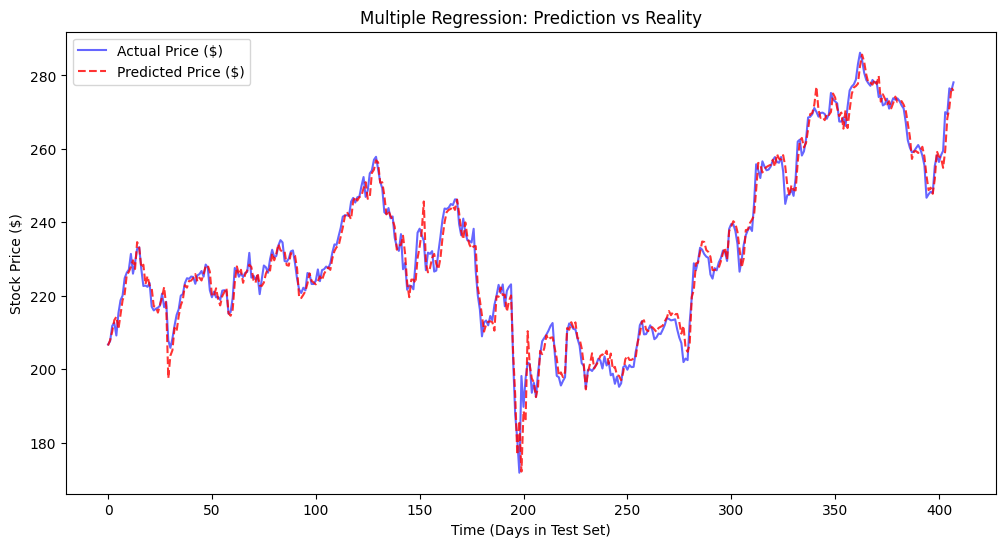

In [12]:

# PART C: MULTIPLE LINEAR REGRESSION (ROBUST VERSION)

# Goal: Predict Apple Price using Market Context.
# FIX: Force float conversion and use Z-Score Standardization to prevent errors.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  LOAD DATA & FORCE NUMBERS

df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()

# We force .astype(float) to ensure no strings/text ruin the math
data['y']    = pd.to_numeric(df_raw['Close']['AAPL'], errors='coerce')
data['Open'] = pd.to_numeric(df_raw['Open']['AAPL'], errors='coerce')
data['Vol']  = pd.to_numeric(df_raw['Volume']['AAPL'], errors='coerce')
data['MSFT'] = pd.to_numeric(df_raw['Close']['MSFT'], errors='coerce')
data['TSLA'] = pd.to_numeric(df_raw['Close']['TSLA'], errors='coerce')

# IMPORTANT: Drop any rows that failed to convert (NaNs)
data = data.dropna()

print(f"Data Loaded Successfully. Rows: {len(data)}")
print("Sample of Data (First 5 rows):")
print(data.head())

#  STANDARDIZATION (Z-SCORE SCALING)

# To make the matrix math stable, we scale data: (X - Mean) / Std Dev
# This makes all values centered around 0 with a range approx -3 to +3.

def standardize(column):
    return (column - column.mean()) / column.std()

# Store mean/std to un-scale later for plotting
y_mean = data['y'].mean()
y_std  = data['y'].std()

# Scale Features
data['Open'] = standardize(data['Open'])
data['Vol']  = standardize(data['Vol'])
data['MSFT'] = standardize(data['MSFT'])
data['TSLA'] = standardize(data['TSLA'])
# Scale Target
data['y_scaled'] = standardize(data['y'])

# Add Bias (Intercept) AFTER scaling. It must be 1.0.
data['Bias'] = 1.0

# 3. MATRIX SETUP

X = data[['Bias', 'Open', 'Vol', 'MSFT', 'TSLA']].values
y = data['y_scaled'].values

# Split 80/20
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nTraining Data Shape: {X_train.shape}")

# 4. TRAINING (NORMAL EQUATION)

# Formula: theta = (X^T * X)^(-1) * X^T * y
# We use pseudo-inverse (pinv) for safety.

def train_normal_equation(X, y):
    X_T = X.T
    XTX = X_T.dot(X)
    XTX_inv = np.linalg.pinv(XTX)
    theta = XTX_inv.dot(X_T).dot(y)
    return theta

theta = train_normal_equation(X_train, y_train)

print("\n--- Learned Coefficients (Standardized) ---")
features = ['Intercept', 'Open', 'Volume', 'MSFT', 'TSLA']
for i, name in enumerate(features):
    print(f"{name:<12}: {theta[i]:.6f}")

# 5. EVALUATION

# Predict
y_pred_scaled = X_test.dot(theta)

# Calculate R2 Score on Scaled Data (Math is the same)
ss_res = np.sum((y_test - y_pred_scaled)**2)
ss_tot = np.sum((y_test - np.mean(y_test))**2)
r2 = 1 - (ss_res / ss_tot)

print(f"\nTest R² Score: {r2:.5f}")

# 6. VISUALIZATION (UN-SCALE FOR REAL PRICES)

# We convert the scaled predictions back to Dollar amounts so the graph makes sense.
# Real_Price = (Scaled_Val * Std_Dev) + Mean

y_test_real = (y_test * y_std) + y_mean
y_pred_real = (y_pred_scaled * y_std) + y_mean

plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Actual Price ($)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicted Price ($)', color='red', linestyle='--', alpha=0.8)
plt.title("Multiple Regression: Prediction vs Reality")
plt.xlabel("Time (Days in Test Set)")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()